# Dependencies

In [1]:
import copy
import sys
import math
from datetime import datetime
import random
import numpy as np
import pandas as pd
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef, auc, accuracy_score, classification_report, recall_score, precision_score, f1_score
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, add, GlobalAveragePooling2D, BatchNormalization, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import load_model
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_path = ""
valid_path = ""
test_path = ""
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)
test = pd.read_csv(test_path)

In [19]:
train_gen = ImageDataGenerator(
            rotation_range=15,
            fill_mode='constant',
            zoom_range=0.1,
            horizontal_flip=True,
            rescale = 1./255
)

validate_gen = ImageDataGenerator(rescale = 1./255)

In [21]:
train_batches = train_gen.flow_from_dataframe(train, 
                                              directory="/tf/notebooks/fishtank/radiology_datasets/", 
                                              x_col="png_path", y_col="ETHNICITY_DESC", 
                                              class_mode="categorical",
                                              target_size=(HEIGHT, WIDTH),
                                              shuffle=True,
                                              seed=2021,
                                              batch_size=BATCH_SIZE, 
                                              dtype='float32')

validate_batches = validate_gen.flow_from_dataframe(valid, 
                                                    directory=None, 
                                                    x_col="png_path", 
                                                    y_col="ETHNICITY_DESC", 
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH),
                                                    shuffle=False,
                                                    batch_size=TEST_BATCH,
                                                    seed=2021,
                                                    dtype='float32')
test_batches = validate_gen.flow_from_dataframe(test, 
                                                    directory=None, 
                                                    x_col="png_path", 
                                                    y_col="ETHNICITY_DESC", 
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH),
                                                    shuffle=False,
                                                    batch_size=TEST_BATCH, 
                                                    seed=2021,
                                                    dtype='float32')

Found 51783 validated image filenames belonging to 2 classes.
Found 17538 validated image filenames belonging to 2 classes.
Found 16991 validated image filenames belonging to 2 classes.


# Training

In [22]:
train_epoch = math.ceil(len(train) / BATCH_SIZE)
val_epoch = math.ceil(len(valid) / TEST_BATCH)

In [23]:
input_a = Input(shape=(HEIGHT, WIDTH, 3))
base_model = efn.EfficientNetB2(input_tensor=input_a, include_top=False, input_shape=(HEIGHT,WIDTH,3), weights='noisy-student')
x = GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(2, name='dense_logits')(x)
output = layers.Activation('softmax', dtype='float32', name='predictions')(x)
model = Model(inputs=input_a, outputs=output)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [25]:
model.compile(optimizer=Adam(lr),
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=[
                        tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
                        tf.keras.metrics.AUC(curve='PR', name='PR-AUC')])

In [26]:
arc_name = "Emory_Mammo" + str(HEIGHT) + "x" + str(WIDTH) + "resnet50-race"

In [27]:
var_date = datetime.now().strftime("%Y%m%d-%H%M%S")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1,
                              patience=2, min_lr=1e-6, verbose=1)
ES = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)
checkloss = ModelCheckpoint("mammo_efficientnetB2_binary.hdf5", monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [28]:

with tf.device("/device:GPU:2"):
    history = model.fit(train_batches,
              validation_data=validate_batches,
              epochs=100,
              steps_per_epoch=int(train_epoch),
              validation_steps=int(val_epoch),
              shuffle=True,
              callbacks=[reduce_lr, checkloss, ES]
              )

Train for 1619 steps, validate for 549 steps
Epoch 1/100
1618/1619 [============================>.] - ETA: 2s - loss: 0.5611 - ROC-AUC: 0.7839 - PR-AUC: 0.7753
Epoch 00001: val_loss improved from inf to 0.53069, saving model to mammo_efficientnetB2_binary.hdf5
1619/1619 [==============================] - 5461s 3s/step - loss: 0.5610 - ROC-AUC: 0.7839 - PR-AUC: 0.7754 - val_loss: 0.5307 - val_ROC-AUC: 0.8152 - val_PR-AUC: 0.8107
Epoch 2/100
1618/1619 [============================>.] - ETA: 3s - loss: 0.4846 - ROC-AUC: 0.8477 - PR-AUC: 0.8428
Epoch 00002: val_loss did not improve from 0.53069
1619/1619 [==============================] - 7017s 4s/step - loss: 0.4847 - ROC-AUC: 0.8476 - PR-AUC: 0.8428 - val_loss: 0.6035 - val_ROC-AUC: 0.7722 - val_PR-AUC: 0.7626
Epoch 3/100
1618/1619 [============================>.] - ETA: 4s - loss: 0.4585 - ROC-AUC: 0.8651 - PR-AUC: 0.8628
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_loss did not impr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dict_keys(['loss', 'ROC-AUC', 'PR-AUC', 'val_loss', 'val_ROC-AUC', 'val_PR-AUC', 'lr'])


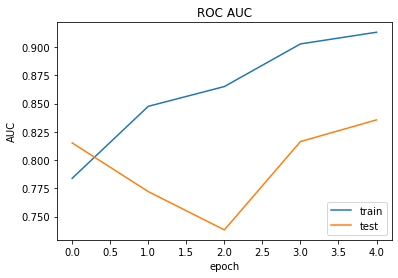

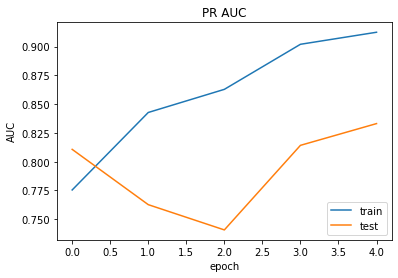

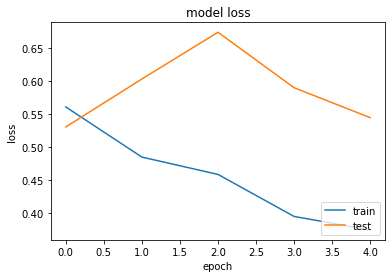

In [29]:
# import seaborn as sns
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['ROC-AUC'])
plt.plot(history.history['val_ROC-AUC'])
plt.title('ROC AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



plt.plot(history.history['PR-AUC'])
plt.plot(history.history['val_PR-AUC'])
plt.title('PR AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()




# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
    
